In [2]:
import numpy as np
import pandas as pd
from spatial_OT.OT import *
from spatial_OT.utils import *
from scipy.spatial import distance
import numpy as np
import scanpy as sc
import anndata as ad
import ot
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
import warnings
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
warnings.filterwarnings('ignore')

In [11]:
'''
An Optimal-Transport based approach for quantifying the spatiotemporal growth of tissues.
'''
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch

def Cost(f, g, Grad, epsilon, device='cpu'):
    '''
    A matrix which is using for the broadcasted log-domain log-sum-exp trick-based updates.
    ------Parameters------
    f: torch.tensor (N1)
        First dual variable of semi-unbalanced Sinkhorn
    g: torch.tensor (N2)
        Second dual variable of semi-unbalanced Sinkhorn
    Grad: torch.tensor (N1 x N2)
        A collection of terms in our gradient for the update
    epsilon: float
        Entropic regularization for Sinkhorn
    device: 'str'
        Device tensors placed on
    '''
    return -( Grad - torch.outer(f, torch.ones(Grad.size(dim=1), device=device)) - torch.outer(torch.ones(Grad.size(dim=0), device=device), g) ) / epsilon

def normalize_M(M, C, N1, _ord='fro'):
    '''
    A function to return normalization constants for the gradient involving the merged feature-spatial matrix,
    which is normalized by a factor related to the interslice feature cost C.
    ------Parameters------
    M: torch.tensor (N x N)
        A symmetric matrix with positive entries (i.e. distance matrix, merged feature-spatial matrix)
    C: torch.tensor (N x M) or (M x N)
        Matrix of pairwise feature distances between slice 1 and 2
    N1: int
        Number of spots in first slice
    '''
    return (torch.linalg.norm(C, ord=_ord)**(1/2) / torch.linalg.norm(M, ord=_ord)) * (N1 )**(1/2)

def LogSinkhorn_iteration(C, D1, D2, C1, C2, Pi_0=None, alpha=0.2, beta=0.5, gamma=50, epsilon=1e-1, max_iter=100, balanced=False, device='cpu', dtype=torch.float64, override_EDM=False, override_FDM=False):
    '''
    Sinkhorn algorithm for the balanced/partially unbalanced case, with log-domain stabilization.
    ------Parameters------
    C: torch.tensor (N1 x N2)
        A matrix of pairwise feature distances between transcript vectors in slice 1 and slice 2 (interslice).
    D1: torch.tensor (N1 x N1)
        A matrix of pairwise Euclidean distances between points in slice 1.
    D2: torch.tensor (N2 x N2)
        A matrix of pairwise Euclidean distances between points in slice 2.
    C1: torch.tensor (N1 x N1)
        A matrix of pairwise feature distances between transcript vectors in slice 1 (intraslice).
    C2: torch.tensor (N2 x N2)
        A matrix of pairwise feature distances between transcript vectors in slice 2 (intraslice).
    Pi_0: torch.tensor (N1 x N2)
        An initialization for the alignment matrix Pi. Should respect marginals of semi-unbalanced or balanced.
    alpha: float
        A balance parameter between the interslice feature term of the objective and the merged feature-spatial term.
    beta: float
        A balance parameter between the GW (quartet) term and the triplet term of the merged feature-spatial term.
    gamma: float
        A hyperparameter controlling the strength of the KL-divergence term in the objective.
    epsilon: float
        A hyperparameter controlling the strength of the entropic regularization in the Sinkhorn algorithm.
    max_iter: int
        The maximal number of iterations DeST-OT is run.
    balanced: bool
        Boolean for whether to default to a balanced OT or to use DeST-OT's semi-unbalanced routine. Default set to False.
    device: str
        Device that torch tensors are placed on. Using GPU/'cuda' is much faster.
    dtype: torch.type
        The default datatype that the alignment and other tensors are in. Ideally torch.float64 or torch.float32
    override_EDM: bool
        Whether to override the merged feature-spatial matrix with a standard Euclidean distance matrix.
    override_FDM:
        Whether to override the merged feature-spatial matrix with an intraslice feature distance matrix.
    '''
    
    N1, N2 = C.size(dim=0), C.size(dim=1)
    
    M1 = D1 * C1
    M2 = D2 * C2
    
    if override_EDM:
        # Override fused matrix with standard EDM
        M1 = D1
        M2 = D2
    elif override_FDM:
        # Override fused matrix with feature distance matrix
        M1 = C1
        M2 = C2
    
    # Normalizing constants
    p1, p2 = normalize_M(M1, C, N1, _ord='fro'), \
                            normalize_M(M2, C, N1, _ord='fro')
    r2, r1 = torch.linalg.norm(C, ord='fro')/torch.linalg.norm(M2**2, ord='fro') * (N1**1/2), \
                            torch.linalg.norm(C, ord='fro')/torch.linalg.norm(M1**2, ord='fro') * (N1 / N2**(1/2))
    
    k = 0
    stationarity_gap = torch.inf
    
    # These are the same for this synthetic data-- change dimensions when we get there
    one_N1 = torch.ones((N1), device=device, dtype=dtype)
    one_N2 = torch.ones((N2), device=device, dtype=dtype)
    
    g1 = one_N1 / N1
    
    if balanced:
        g2 = one_N2 / N2
    else:
        g2 = one_N2 / N1
    
    log_g1 = torch.log(g1)
    log_g2 = torch.log(g2)
    
    if Pi_0 is None:
        # Will converge to partially balanced marginal
        Pi_0 = torch.outer(g1, g2).to(device)
    
    Pi_k = Pi_0
    
    f_k = torch.zeros((N1), device=device)
    g_k = torch.zeros((N2), device=device)
    
    errs = []
    
    # unbalanced coefficient
    ubc = gamma/(gamma + epsilon)
    
    grad = torch.inf
    while k < max_iter:
        
        # Offering the user the option to choose their energy-regularization
        dist_orig = r1*(M1**2 @ Pi_k) + r2*(Pi_k @ M2**2)
        
        if balanced:
            dist_GW = -2 * ((p1*M1) @ Pi_k @ (p2*M2)) 
        else:
            dist_GW = -2*((p1*M1) @ Pi_k @ (p2*M2).T) + (p1*M1)**2 @ Pi_k @ torch.ones((N2, N2), device=device, dtype=dtype)
        
        grad = (1-alpha)*C + alpha*(beta*dist_orig + (1-beta)*dist_GW)
        
        if balanced:
            f_k = f_k + epsilon*(log_g1 - torch.logsumexp(Cost(f_k, g_k, grad, epsilon, device=device), axis=1))
            g_k = g_k + epsilon*(log_g2 - torch.logsumexp(Cost(f_k, g_k, grad, epsilon, device=device), axis=0))
        elif balanced is False:
            # Partially unbalanced coefficient used on one of the dual variables
            f_k = ubc*(f_k + epsilon*(log_g1 - torch.logsumexp(Cost(f_k, g_k, grad, epsilon, device=device), axis=1)) )
            g_k = g_k + epsilon*(log_g2 - torch.logsumexp(Cost(f_k, g_k, grad, epsilon, device=device), axis=0))
        
        Pi = torch.exp(Cost(f_k, g_k, grad, epsilon, device=device))
        # Checking whether we're approaching a fixed point
        stationarity_gap = torch.linalg.norm(Pi_k - Pi, ord='fro')
        Pi_k = Pi
        
        k+=1
        errs.append(stationarity_gap)
    
    xi = (Pi_k @ one_N2 - g1)
    
    return xi, Pi_k, errs

import torch
import anndata as ad
import scanpy as sc
import numpy as np
from scipy.spatial import distance
from pynvml import *


def intersect(lst1, lst2): 
    """
    param: lst1 - list
    param: lst2 - list
    
    return: list of common elements
    """
    temp = set(lst2)
    lst3 = [value for value in lst1 if value in temp]
    return lst3 

"""
This function to select a GPU is from the scSLAT package.
"""
def get_free_gpu() -> int:
    """
    Get index of GPU with least memory usage
    
    Ref
    ----------
    https://stackoverflow.com/questions/58216000/get-total-amount-of-free-gpu-memory-and-available-using-pytorch
    """
    nvmlInit()
    index = 0
    max = 0
    for i in range(torch.cuda.device_count()):
        h = nvmlDeviceGetHandleByIndex(i)
        info = nvmlDeviceGetMemoryInfo(h)
        index = i if info.free > max else index
        max = info.free if info.free > max else max
        
    # seed = np.random.randint(1000)
    # os.system(f'nvidia-smi -q -d Memory |grep Used > gpu-{str(seed)}.tmp')
    # memory_available = [int(x.split()[2]) for x in open('gpu.tmp', 'r').readlines()]
    # os.system(f'rm gpu-{str(seed)}.tmp')
    # print(memory_available)
    return index

def xi_to_growth_rate(xi, t1=0, t2=1, normalize_xi=True):
    '''
    Returns a differential growth rate given the growth vector xi.
    
    Parameters:
    xi: numpy array (N1)
        Growth vector quantifying the raw mass-flux
    t1: float
        First observation timepoint
    t2: float
        Second observation timepoint
    normalize_xi: bool
        True if xi normalized to number of cells units (this is the default output of align, using the same flag "normalize_xi"),
        False if xi directly computed from Pi without renormalization.
    '''
    N1 = xi.shape[0]
    if normalize_xi is False:
        Js = np.log(N1*xi + 1) / (t2 - t1)
    else:
        Js = np.log(xi + 1) / (t2 - t1)
    # Returning a proper growth-rate given mass-flux xi
    return Js

def align(slice_t1, slice_t2, alpha=0.2, gamma=50, epsilon=1e-1, max_iter=100, balanced=False, use_gpu=True, normalize_xi=True, check_convergence=False):
    """
    Run DeST-OT

    Parameters:
    slice_t1: AnnData object
        The AnnData object of the first slice, with .obsm['spatial'] field storing the spatial coordinates
    slice_t2: AnnData object
        The AnnData object of the second slice, with .obsm['spatial'] field storing the spatial coordinates
    alpha: float
        A balance parameter between the interslice feature term of the objective and the merged feature-spatial term. Default is 0.2.
    gamma: float
        A hyperparameter controlling the strength of the KL-divergence term in the objective. Default is 50.
    epsilon: float
        A hyperparameter controlling the strength of the entropic regularization in the Sinkhorn algorithm. Default is 0.1.
    max_iter: int
        The maximal number of iterations DeST-OT is run. Default is 100.
    balanced: bool
        Boolean for whether to default to a balanced OT or to use DeST-OT's semi-unbalanced routine. Default set to False.
    use_gpu: bool
        Boolean for whether to use GPU. Default is True.
    normalize_xi: bool
        Boolean for whether to normalize the growth vector xi to the unit of number of spots. If True, each entry in xi will be in the unit of number of spots, e.g. xi_i = 1 means spots i will grow into two spots in the next timepoint. Default is False.
        Note: set to False when use the output xi to compute the growth distortion metric.
    check_convergence: bool
        Boolean for whether to return the stationarity gap with respect to Pi for each iteration.

    Returns:
    Pi: numpy array of shape (N1 x N2)
        The alignment matrix
    xi: numpy array of shape (N1)
        The growth vector
    errs: list of size (max_iter)
        If check_convergence is True, return a list of stationarity gaps for each iterations. Used for checking the convergence of Pi.
    """
    X = slice_t1.X.toarray()
    Y = slice_t2.X.toarray()
    
    C = distance.cdist(X, Y)
    C1 = distance.cdist(X, X)
    C2 = distance.cdist(Y, Y)
    # Calculate spatial distances
    D1 = distance.cdist(slice_t1.obsm['spatial'], slice_t1.obsm['spatial'])
    D2 = distance.cdist(slice_t2.obsm['spatial'], slice_t2.obsm['spatial'])

    # Pytorch
    if use_gpu:
        gpu_index = get_free_gpu()
        device = torch.device(f'cuda:{gpu_index}' if torch.cuda.is_available() else 'cpu')
    else:
        device='cpu'
    C = torch.from_numpy(C).to(device)
    C1 = torch.from_numpy(C1).to(device)
    C2 = torch.from_numpy(C2).to(device)
    D1 = torch.from_numpy(D1).to(device)
    D2 = torch.from_numpy(D2).to(device)

    # Run DeST-OT
    xi, Pi, errs = LogSinkhorn_iteration(C, D1, D2, C1, C2, alpha=alpha, gamma=gamma, epsilon=epsilon, max_iter=max_iter, balanced=balanced, device=device)
    Pi = Pi.cpu().detach().numpy()
    xi = xi.cpu().detach().numpy()

    lseed=0
    rseed=1
    np.random.seed(lseed)
    np.random.seed(rseed)
    batch_size=1000
    lidx = np.random.randint(0, X.shape[0], size=batch_size)
    np.random.seed(rseed)
    ridx = np.random.randint(0, Y.shape[0], size=batch_size)
    C = distance.cdist(X[lidx], Y[ridx], metric="euclidean")
    Pi_sub = Pi[np.ix_(lidx, ridx)] 
    destot_dist = C * Pi_sub
    sum_destot = np.sum(destot_dist)

    if normalize_xi:
        xi = slice_t1.shape[0] * xi
    if check_convergence:
        return Pi, xi, errs, 
    return Pi, xi, sum_destot

import numpy as np
import scanpy as sc
from scipy.spatial import distance
import pandas as pd


def partial_procrustes_analysis(X, Y, pi):
    m = np.sum(pi)
    Z = (X - pi.sum(axis=1).dot(X) * (1.0 / m)).T
    W = (Y - pi.sum(axis=0).dot(Y) * (1.0 / m)).T
    H = W.dot(pi.T.dot(Z.T))
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T.dot(U.T)
    W = R.dot(W)
    return Z.T, W.T


def partial_stack_slices_pairwise(slices, pis):
    assert len(slices) == len(pis) + 1, "'slices' should have length one more than 'pis'. Please double check."
    assert len(slices) > 1, "You should have at least 2 layers."

    new_coor = []
    S1, S2 = partial_procrustes_analysis(slices[0].obsm['spatial'], slices[1].obsm['spatial'], pis[0])
    new_coor.append(S1)
    new_coor.append(S2)
    for i in range(1, len(slices) - 1):
        x, y = partial_procrustes_analysis(new_coor[i], slices[i + 1].obsm['spatial'], pis[i])
        shift = new_coor[i][0,:] - x[0,:]
        y = y + shift
        new_coor.append(y)
    new_slices = []
    for i in range(len(slices)):
        s = slices[i].copy()
        s.obsm['spatial'] = new_coor[i]
        new_slices.append(s)
    return new_slices


def transition_mat(Pi, celltypes1, celltypes2):
    """
    Compute the cell type transition matrix from an alignment matrix Pi (Eq. 10 of the paper)

    Parameters:
    Pi: numpy array of shape (N1, N2)
        The alignment matrix
    celltype1: numpy array of shape N1
        An array of celltypes for each spot on slice t1
    celltype2: numpy array of shape N2
        An array of celltypes for each spot on slice t2

    Return:
    The cell type transition matrix, a numpy array of shape (N_CT, N_CT), where N_CT is the total number of cell types
    """
    celltypes_all = np.unique(np.concatenate((celltypes1,celltypes2), axis=0))
    N_CT = celltypes_all.shape[0]
    
    T = np.zeros((N_CT, N_CT))
    for i in range(N_CT):
        for j in range(N_CT):
            ct_i = celltypes_all[i]
            ct_j = celltypes_all[j]
            mask = np.outer((celltypes1 == ct_i), (celltypes2 == ct_j))
            T[i,j] = np.sum(Pi[mask])
    
    col_sums = T.sum(axis=0)
    non_zero_cols = col_sums != 0
    T[:, non_zero_cols] /= col_sums[non_zero_cols]

    return T


def growth_distortion_metric_helper(xi, celltypes1, celltypes2, T=None):
    '''
    Implementation of the growth distortion metric given the inferred growth vector xi

    Parameters:
    xi: numpy array of shape (N1, N2)
        The growth vector of a spatiotemporal alignment
    celltype1: numpy array of shape N1
        An array of celltypes for each spot on slice t1
    celltype2: numpy array of shape N2
        An array of celltypes for each spot on slice t2
    T: numpy array of shape (N1, N2)
        A cell type transition matrix to compute the growth distortion metric under.

    Returns:
    the growth distortion metric
    '''
    N1 = xi.shape[0]
    if T is not None:
        celltypes = np.unique(np.concatenate((celltypes1,celltypes2), axis=0))
    else:
        celltypes = np.intersect1d(celltypes1, celltypes2)
    
    distortion_measure = 0
    
    N_C = len(celltypes)
    m_t = np.zeros(N_C)
    m_tm1 = np.zeros(N_C)
    
    for p, celltype in np.ndenumerate(celltypes):
        m_t[p] = np.sum(celltypes2 == celltype)
        m_tm1[p] = np.sum(celltypes1 == celltype)
    
    if T is not None:
        # Transition-matrix adjusted assignment of mass-fluxes
        m_t = T @ m_t
    
    # Quantifying the accuracy of matching true baseline growth rates
    growth_rates = np.zeros(celltypes.shape[0])
    for p, celltype in np.ndenumerate(celltypes):
        dmP = (m_t[p] - m_tm1[p])/N1
        growth_rates[p] = gamma_tp = (1/N1)*((m_t[p] - m_tm1[p])/m_tm1[p])
        xi_p = xi[celltypes1 == celltype]
        # Sum of squares error of individual cell growth rates,
        # relative to true cell type specific growth rate.
        distortion_measure += np.sum( (xi_p - gamma_tp * np.ones(xi_p.shape[0]) )**2 )
            
    # print(f'Distortion metric value: {N1*distortion_measure}')
    return N1 * distortion_measure


def growth_distortion_metric(slice_t1, slice_t2, Pi, xi=None, annotation_key="annotation", option="infer_transition"):
    """
    Compute the growth distortion metric given two slices, an alignment matrix Pi, and a growth vector xi

    Parameters:
    slice_t1: AnnData object
        The AnnData object of the first slice, with .obs['annotation'] field storing the cell type of each spot.
    slice_t2: AnnData object
        The AnnData object of slice t2, with .obs['annotation'] field storing the cell type of each spot.
    Pi: numpy array of shape (N1, N2)
        Alignment matrix between slice t1 and slice t2
    xi: numpy array of shape (N1) or NoneType
        The growth vector from the alignment. If not input, then recomputed from Pi.
    annotation_key: String
        The key for the cell-type annotations in the AnnData object
    option: String, one of the following two options
        "no_transition": Assumes no cell type transition, and the growth distortion metric is calculcated based on the intersection of cell types in the two slices
        "infer_transition": Assumes cell type transition during development, and the growth distortion metric is calculated based on the cell type transition matrix of all cell types that minimizes the growth distortion metric for the given Pi (Section 2.3.1 of the paper)

    Returns:
    The growth distortion metric of the given Pi and xi
    """
    if xi is None:
        one_N2 = np.ones(Pi.shape[1])
        g1 = np.ones(Pi.shape[0])/Pi.shape[0]
        xi = (Pi @ one_N2 - g1)
    else:
        pass
    l1, l2 = slice_t1.obs[annotation_key].tolist(), slice_t2.obs[annotation_key].tolist()
    l_merged = l1 + l2
    categorical_labels, celltypes = pd.factorize(l_merged)
    celltypes1 = categorical_labels[:len(l1)]
    celltypes2 = categorical_labels[len(l1):]

    if option == 'no_transition':
        T = None
    elif option == 'infer_transition':
        T = transition_mat(Pi, celltypes1, celltypes2)
    else:
        raise Exception('Invalid Option')
    
    return growth_distortion_metric_helper(xi, celltypes1, celltypes2, T)


def migration_metric(slice_t1, slice_t2, Pi):
    """
    Compute the migration metric given two slices and an aligment matrix Pi

    Parameters:
    slice_t1: AnnData object
        An AnnData object of slice t1, with .obsm['spatial'] field storing the spatial coordinates.
    slice_t2: AnnData object
        An AnnData object of slice t2, with .obsm['spatial'] field storing the spatial coordinates.
    Pi: numpy array of shape (N1 x N2)
        Alignment matrix between slice t1 and slice t2

    Returns:
    The migration metric of Pi
    """
    slice_t1_newcoor_adata, slice_t2_newcoor_adata = partial_stack_slices_pairwise([slice_t1, slice_t2], [Pi])
    
    slice_t1_newcoor = slice_t1_newcoor_adata.obsm['spatial']
    slice_t2_newcoor = slice_t2_newcoor_adata.obsm['spatial']
    
    V = distance.cdist(slice_t2_newcoor, slice_t1_newcoor)
    
    # Handling zero entries in Pi @ 1_n (i.e. spot not mapped at all to next timepoint)
    ma = (Pi @ np.ones(Pi.shape[1])) > 0

    Pi_hat = Pi[ma, :] / (Pi @ np.ones(Pi.shape[1]))[ma][:, None]
    # Pi_hat = pi / (pi @ np.ones(pi.shape[1]))[:, None]
    V = V[:,ma]

    migs = np.einsum('ij,ji->i', Pi_hat, V)
    
    avg_weighted_migration_distance = np.mean(migs)
    return avg_weighted_migration_distance

import numpy as np
import scanpy as sc
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import jensenshannon

def compute_transported_adata_argmax(adata_source, adata_target, transport_matrix):
    """
    Compute transported AnnData object using the argmax method.

    Parameters:
        adata_source (AnnData): Original AnnData before transport.
        adata_target (AnnData): Target AnnData after transport.
        transport_matrix (ndarray): Transport matrix (N_source x N_target).

    Returns:
        AnnData: New AnnData with updated spatial coordinates.
    """
    # Extract spatial coordinates
    spatial_target = adata_target.obsm["spatial"]

    # Find the target index with the highest probability for each source cell
    max_indices = np.argmax(transport_matrix, axis=1)  # Shape: (N_source,)

    # Assign new spatial positions from the most probable target cell
    spatial_transported = spatial_target[max_indices]  # Shape: (N_source, 2)

    # Create a new AnnData object for transported data
    adata_transported = adata_source.copy()
    adata_transported.obsm["spatial"] = spatial_transported  # Update spatial positions

    return adata_transported

def compute_local_cell_type_distribution(adata, k=10):
    """
    Compute the local cell-type distribution for each cell.

    Parameters:
        adata (AnnData): AnnData object with spatial coordinates and cell types.
        k (int): Number of nearest neighbors to consider.

    Returns:
        ndarray: Local cell-type distributions (N_cells x N_cell_types).
    """
    # Extract spatial coordinates and cell types
    spatial_coords = adata.obsm["spatial"]
    cell_types = adata.obs["unsupervised_label"].astype("category").cat.codes.values  # Convert categorical to numerical
    unique_types = np.unique(cell_types)  # Get unique cell type indices
    num_types = len(unique_types)  # Number of unique cell types

    # Compute k-nearest neighbors
    knn = NearestNeighbors(n_neighbors=k).fit(spatial_coords)
    neighbors = knn.kneighbors(spatial_coords, return_distance=False)

    # Compute local cell-type distribution
    local_distributions = np.zeros((spatial_coords.shape[0], num_types))

    for i in range(spatial_coords.shape[0]):
        neighbor_types = cell_types[neighbors[i]]  # Get types of neighbors
        for j, cell_type in enumerate(unique_types):
            local_distributions[i, j] = np.sum(neighbor_types == cell_type) / k  # Normalize

    return local_distributions

def compute_js_divergence_before_after(adata_source, adata_transported, k=5):
    """
    Compute the average Jensen-Shannon (JS) divergence between the local cell-type distributions
    before and after transport.

    Parameters:
        adata_source (AnnData): Original AnnData before transport.
        adata_transported (AnnData): AnnData after transport.
        k (int): Number of nearest neighbors to consider.

    Returns:
        float: Average JS divergence across all cells.
    """
    # Compute local cell-type distributions
    source_distributions = compute_local_cell_type_distribution(adata_source, k)
    transported_distributions = compute_local_cell_type_distribution(adata_transported, k)

    # Compute JS divergence for each cell
    js_divergences = [
        jensenshannon(source_distributions[i], transported_distributions[i])
        for i in range(source_distributions.shape[0])
    ]

    # Return average JS divergence across all cells
    return np.mean(js_divergences)


def compute_accuracy_max_prob(transport_matrix, source_labels, target_labels):

    source_labels = np.asarray(source_labels)
    target_labels = np.asarray(target_labels)

    # Get the target cell index with max probability for each source cell
    max_prob_indices = np.argmax(transport_matrix, axis=1)
    
    # Predicted cell types based on max probability
    predicted_labels = target_labels[max_prob_indices]
    # Compare predicted labels with source labels
    correct_predictions = (source_labels == predicted_labels)
    
    # Compute accuracy
    accuracy = correct_predictions.mean()
    
    return accuracy

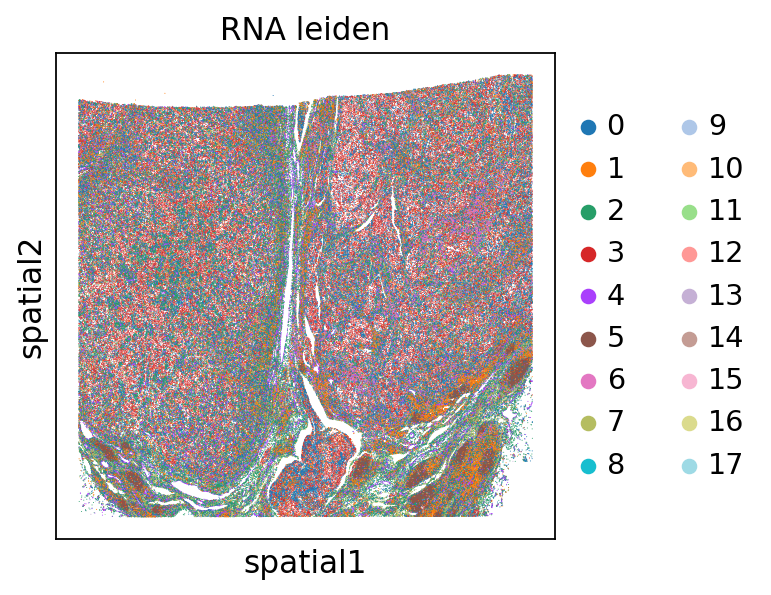

In [4]:
k = 5
alpha = 0.5  
epsilon = 0.1  

protein = sc.read_h5ad("/home/fceccarelli/home3/tmp/rna.h5ad")
sc.settings.set_figure_params(dpi_save=250)
sc.pl.embedding(
    protein,
    basis="spatial",
    color="unsupervised_label",
    title="RNA leiden",
    s=0.8,
    save="_protein_leiden.pdf"   
)

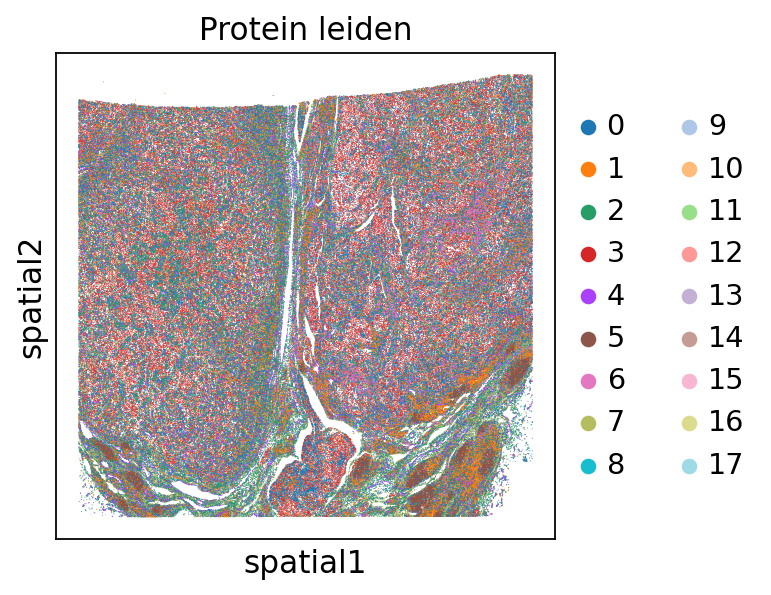

In [5]:
rna = sc.read_h5ad("/home/fceccarelli/home3/tmp/protein.h5ad")

sc.pl.embedding(
    rna,
    basis="spatial",
    color="unsupervised_label",
    title="Protein leiden",
    s=0.8 
)

In [6]:
rna.var_names == protein.var_names

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [7]:
def accuracy_true_matching(transport):
    """
    Accuracy = fraction of RNA cells whose top transport match is the correct protein cell.
    """
    pred = transport.argmax(axis=1)
    true = np.arange(transport.shape[0])

    return (pred == true).mean()

In [13]:
# Store results
results = []

def compute_spatial_fgw_alignment(slice1, slice2, alpha, epsilon):
    """Compute FGW and FGW-SN alignment and return accuracy and JS divergence scores."""
   
    X = slice1.X.toarray()
    Y = slice2.X.toarray()
    
    # Compute spatial graphs
    coords1 = pd.DataFrame(slice1.obsm["spatial"], columns=["x", "y"])
    X_df = pd.DataFrame(X, columns=[f"PC{i+1}" for i in range(X.shape[1])])
    
    X_df["x"], X_df["y"], X_df["cell_type"] = coords1["x"].values, coords1["y"].values, slice1.obs["unsupervised_label"].values

    G1 = build_knn_graph_from2d(X_df, k=k)
    X_df["spatial_entropy"] = X_df.index.map(compute_spatial_entropy(G1))
    slice1_avg_expr = compute_average_neighbor_expression(G1, pd.DataFrame(X))
    
    coords2 = pd.DataFrame(slice2.obsm["spatial"], columns=["x", "y"])
    Y_df = pd.DataFrame(Y, columns=[f"PC{i+1}" for i in range(Y.shape[1])])
    Y_df["x"], Y_df["y"], Y_df["cell_type"] = coords2["x"].values, coords2["y"].values, slice2.obs["unsupervised_label"].values

    G2 = build_knn_graph_from2d(Y_df, k=k)
    Y_df["spatial_entropy"] = Y_df.index.map(compute_spatial_entropy(G2))
    slice2_avg_expr = compute_average_neighbor_expression(G2, pd.DataFrame(Y))
    
    # Compute cost matrices
    M = distance.cdist(X, Y).astype(float)
    C1 = distance.cdist(slice1.obsm["spatial"], slice1.obsm["spatial"]).astype(float)
    C2 = distance.cdist(slice2.obsm["spatial"], slice2.obsm["spatial"]).astype(float)
    C3 = np.abs(X_df["spatial_entropy"].values[:, np.newaxis] - Y_df["spatial_entropy"].values[np.newaxis, :])
    C4 = distance.cdist(slice1_avg_expr.values, slice2_avg_expr.values).astype(float)

    # Normalize matrices
    for mat in [M, C1, C2, C3, C4]:
        mat /= mat.max() if mat.max() > 0 else 1  # Avoid division by zero
    
    # Compute transport maps
    p, q = ot.unif(X.shape[0]), ot.unif(Y.shape[0])
    G0 = np.outer(p, q)

    FGW = compute_transport(G0, epsilon, alpha, C1, C2, p, q, M)
    FGW_SN = compute_transport(G0, epsilon, alpha, C1, C2, p, q, M, C3, C4)

    acc_fgw = accuracy_true_matching(FGW)
    acc_fgw_sn = accuracy_true_matching(FGW_SN)

    acc_fgw_cluster = compute_accuracy_max_prob(FGW, slice1.obs['unsupervised_label'], slice2.obs['unsupervised_label'])
    acc_fgw_sn_cluster = compute_accuracy_max_prob(FGW_SN, slice1.obs['unsupervised_label'], slice2.obs['unsupervised_label'])
    
    # Compute JS divergence
    js_fgw = compute_js_divergence_before_after(slice1, compute_transported_adata_argmax(slice1, slice2, FGW), k=20)
    js_fgw_sn = compute_js_divergence_before_after(slice1, compute_transported_adata_argmax(slice1, slice2, FGW_SN), k=20)

    return acc_fgw, acc_fgw_sn, acc_fgw_cluster, acc_fgw_sn_cluster, js_fgw, js_fgw_sn

In [9]:
alpha = 0.5  
epsilon = 0.1 

In [14]:
def assign_grid(adata, grid_size=100):
    x = adata.obsm["spatial"][:, 0]
    y = adata.obsm["spatial"][:, 1]

    # Compute grid indices
    grid_x = (x // grid_size).astype(int)
    grid_y = (y // grid_size).astype(int)

    # Convert to Python strings BEFORE concatenating
    grid_x_str = grid_x.astype(str).astype(object)
    grid_y_str = grid_y.astype(str).astype(object)

    adata.obs["grid_id"] = grid_x_str + "_" + grid_y_str

    return adata

rna = assign_grid(rna, grid_size=100)
protein = assign_grid(protein, grid_size=100)

rna_bins = set(rna.obs["grid_id"])
prot_bins = set(protein.obs["grid_id"])

common_bins = list(rna_bins.intersection(prot_bins))
print("Common grids:", len(common_bins))

Common grids: 6340


In [15]:
results = []
transport_list_fgw = []
transport_list_fgw_sn = []


for i, g in enumerate(common_bins):
    print(f"Running alignment on grid {i}")

    rna_g = rna[rna.obs["grid_id"] == g].copy()
    prot_g = protein[protein.obs["grid_id"] == g].copy()

    # Skip tiny grids
    if rna_g.n_obs < 20 or prot_g.n_obs < 20:
        continue

    acc_fgw, acc_fgw_sn, acc_fgw_cluster, acc_fgw_sn_cluster, js_fgw, js_fgw_sn = \
        compute_spatial_fgw_alignment(rna_g, prot_g, alpha, epsilon)

    Pi, _, _ = align(rna_g, prot_g, alpha=0.2, gamma=50, epsilon=0.1, max_iter=100, balanced=False, use_gpu=False, normalize_xi=True, check_convergence=False)
    acc_dest = accuracy_true_matching(Pi)
    
    acc_dest_cluster = compute_accuracy_max_prob(Pi, rna_g.obs['unsupervised_label'], prot_g.obs['unsupervised_label'])
    js_dest = compute_js_divergence_before_after(rna_g, compute_transported_adata_argmax(rna_g, prot_g, Pi), k=20)
    
    # Save results
    results.append({
        "grid": g,
        "ACC_FGW": acc_fgw,
        "ACC_TOAST": acc_fgw_sn,
        "ACC_DEST": acc_dest,
        "ACC_FGW_CLUSTER": acc_fgw_cluster,
        "ACC_TOAST_CLUSTER": acc_fgw_sn_cluster,
        "ACC_DEST_CLUSTER": acc_dest_cluster,
        "JS_FGW": js_fgw,
        "JS_TOAST": js_fgw_sn,
        "JS_DEST": js_dest,
    })

Running alignment on grid 0
Running alignment on grid 1
Running alignment on grid 2
Running alignment on grid 3
Running alignment on grid 4
Running alignment on grid 5
Running alignment on grid 6
Running alignment on grid 7
Running alignment on grid 8
Running alignment on grid 9
Running alignment on grid 10
Running alignment on grid 11
Running alignment on grid 12
Running alignment on grid 13
Running alignment on grid 14
Running alignment on grid 15
Running alignment on grid 16
Running alignment on grid 17
Running alignment on grid 18
Running alignment on grid 19
Running alignment on grid 20
Running alignment on grid 21
Running alignment on grid 22
Running alignment on grid 23
Running alignment on grid 24
Running alignment on grid 25
Running alignment on grid 26
Running alignment on grid 27
Running alignment on grid 28
Running alignment on grid 29
Running alignment on grid 30
Running alignment on grid 31
Running alignment on grid 32
Running alignment on grid 33
Running alignment on gri

In [16]:
import pandas as pd
df = pd.DataFrame(results)

print("Mean Acc FGW:", df["ACC_FGW"].mean())
print("Mean Acc TOAST:", df["ACC_TOAST"].mean())
print("Mean Acc DeST-OT:", df["ACC_DEST"].mean())

Mean Acc FGW: 0.07568333342545562
Mean Acc TOAST: 0.5611995166915473
Mean Acc DeST-OT: 0.03113602646155727


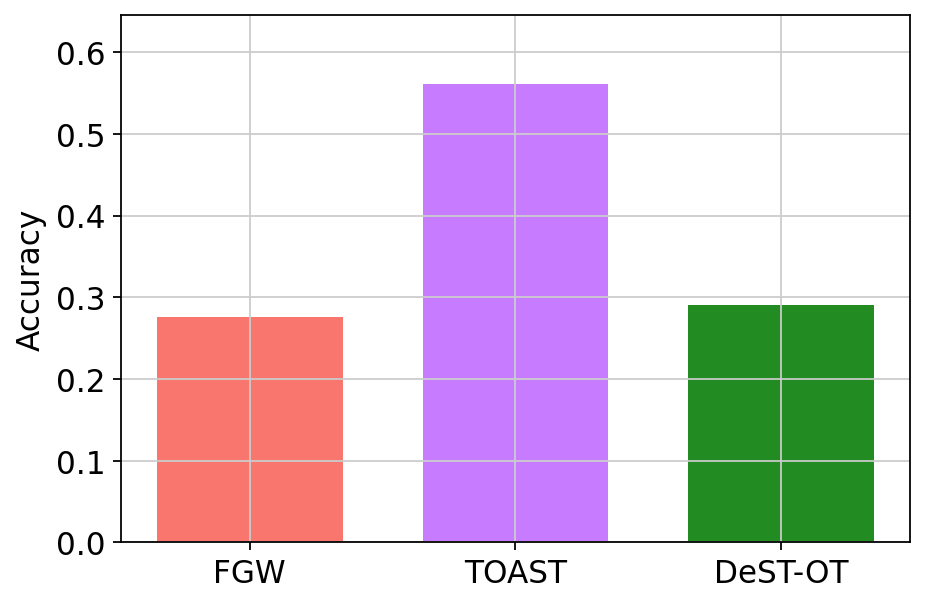

Mean Acc FGW: 0.27568333342545565
Mean Acc TOAST: 0.5611995166915473
Mean Acc DeST-OT: 0.2911360264615573


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results)

# Compute means
mean_acc_fgw  = 0.27568333342545562
mean_acc_toast = 0.5611995166915473
mean_acc_dest  = 0.29113602646155727

# Data for plot
labels = ["FGW", "TOAST", "DeST-OT"]
acc_values = [mean_acc_fgw, mean_acc_toast, mean_acc_dest]

colors = ["#F8766D", "#C77CFF", "#228B22"]   # red, purple, green

plt.figure(figsize=(6,4))
plt.bar(labels, acc_values, color=colors, width=0.7)

plt.ylabel("Accuracy")

plt.ylim(0, max(acc_values) * 1.15)
plt.tight_layout()
plt.savefig("mean_accuracy_methods.pdf", dpi=300, bbox_inches="tight")
plt.show()

print("Mean Acc FGW:", mean_acc_fgw)
print("Mean Acc TOAST:", mean_acc_toast)
print("Mean Acc DeST-OT:", mean_acc_dest)

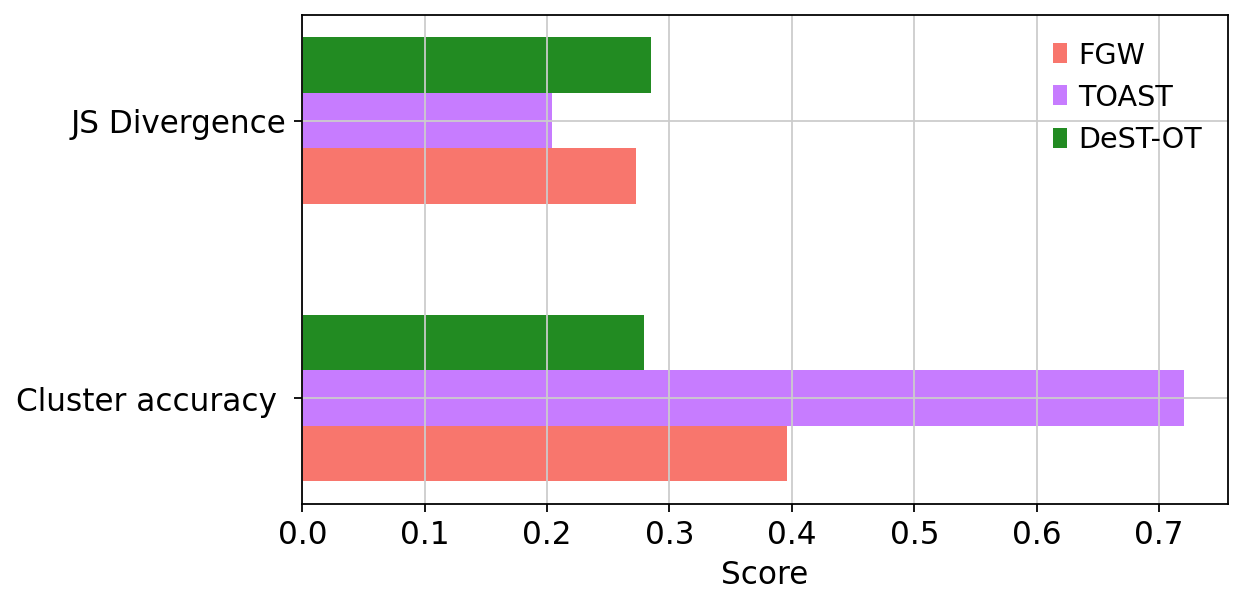

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.DataFrame(results)

# Metric means
acc_cluster = [
    df["ACC_FGW_CLUSTER"].mean(),
    df["ACC_TOAST_CLUSTER"].mean(),
    df["ACC_DEST_CLUSTER"].mean()
]

js_values = [
    df["JS_FGW"].mean(),
    df["JS_TOAST"].mean(),
    df["JS_DEST"].mean()
]

methods = ["FGW", "TOAST", "DeST-OT"]
colors  = ["#F8766D", "#C77CFF", "#228B22"]

# ---- Re-group by metric ----
metrics = ["Cluster accuracy ", "JS Divergence"]
metric_values = [acc_cluster, js_values]

plt.figure(figsize=(8, 4))

# y positions: 2 metric groups
y_base = np.arange(len(metrics))
bar_height = 0.2

for i, method in enumerate(methods):
    plt.barh(
        y_base + (i - 1) * bar_height,   # shift bars vertically
        [metric_values[m][i] for m in range(len(metrics))],
        height=bar_height,
        color=colors[i],
        label=method
    )

plt.xlabel("Score")
plt.yticks(y_base, metrics)
plt.legend(loc="upper right", frameon=False)


plt.tight_layout()
plt.savefig("grouped_horizontal_metrics_by_metric.pdf", dpi=300, bbox_inches="tight")
plt.show()

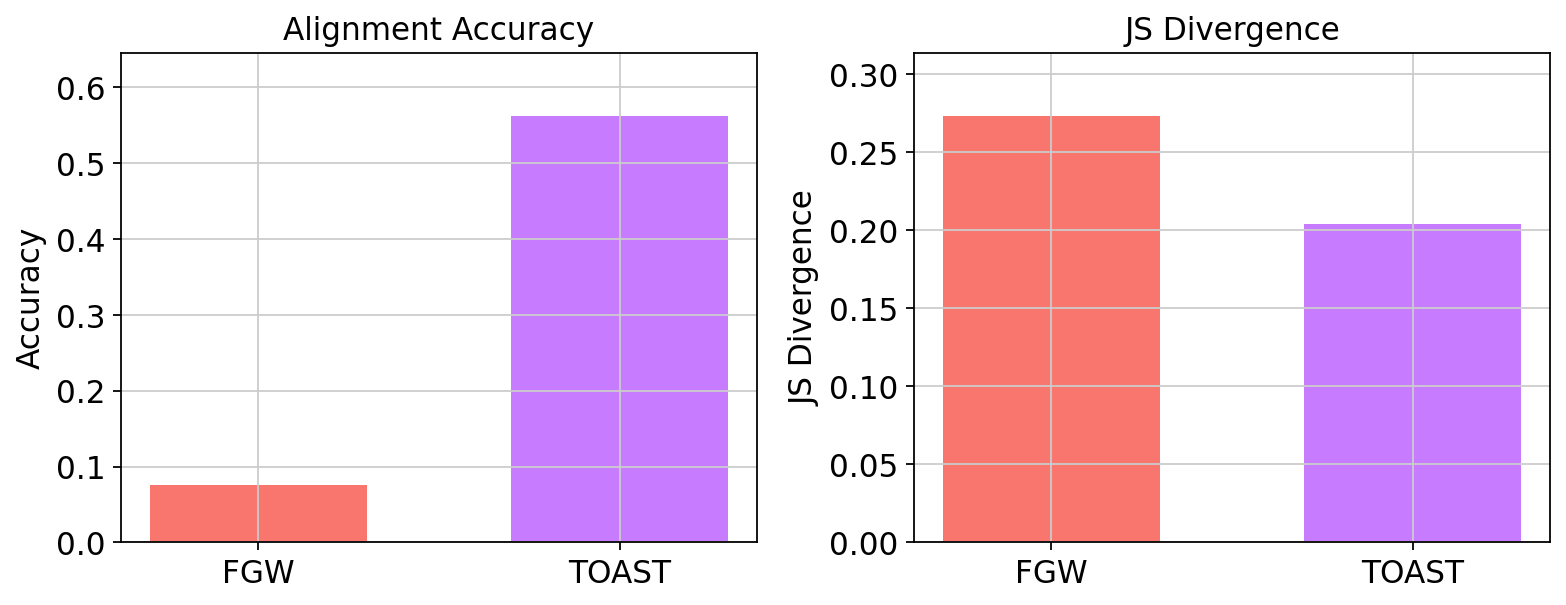

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results)

# Compute means
mean_acc_fgw = df["ACC_FGW"].mean()
mean_acc_toast = df["ACC_TOAST"].mean()

mean_js_fgw = df["JS_FGW"].mean()
mean_js_toast = df["JS_TOAST"].mean()

# Data for barplots
labels = ["FGW", "TOAST"]

acc_values = [mean_acc_fgw, mean_acc_toast]
js_values  = [mean_js_fgw,  mean_js_toast]

# Color scheme: FGW = orange, TOAST = blue
colors = ["#F8766D", "#C77CFF"]  

# -----------------------------
# Combined figure with subplots
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --- Panel A: Accuracy ---
axes[0].bar(labels, acc_values, color=colors, width=0.6)
axes[0].set_title("Alignment Accuracy")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim(0, max(acc_values) * 1.15)

# --- Panel B: JS Divergence ---
axes[1].bar(labels, js_values, color=colors, width=0.6)
axes[1].set_title("JS Divergence")
axes[1].set_ylabel("JS Divergence")
axes[1].set_ylim(0, max(js_values) * 1.15)

plt.tight_layout()
plt.savefig("mean_accuracy_js_combined.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.DataFrame(results)

# Compute means
mean_acc_fgw = df["ACC_FGW"].mean()
mean_acc_toast = df["ACC_TOAST"].mean()

mean_js_fgw = df["JS_FGW"].mean()
mean_js_toast = df["JS_TOAST"].mean()

# Grouped plot data
metrics = ["Accuracy", "JS Divergence"]

fgw_values   = [mean_acc_fgw, mean_js_fgw]
toast_values = [mean_acc_toast, mean_js_toast]

x = np.arange(len(metrics))  # positions for groups
width = 0.35  # width of each bar

# Colors
fgw_color   = "#F8766D"  # Orange
toast_color = "#C77CFF"  # Blue

plt.figure(figsize=(8, 5))

# FGW bars (left)
plt.bar(x - width/2, fgw_values, width, label="FGW", color=fgw_color)

# TOAST bars (right)
plt.bar(x + width/2, toast_values, width, label="TOAST", color=toast_color)

# Labels
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Comparison of FGW vs TOAST")
plt.legend()

plt.tight_layout()
plt.savefig("grouped_accuracy_js_plot.pdf", dpi=300, bbox_inches="tight")
plt.show()